In [1]:
# This extension allows us to immediately sync changes from utils.
%reload_ext autoreload
%autoreload 1
%aimport src.utils

import os
from matplotlib import pyplot as plt
import numpy as np
import scipy.io as sio
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src import utils


data exists; not downloading


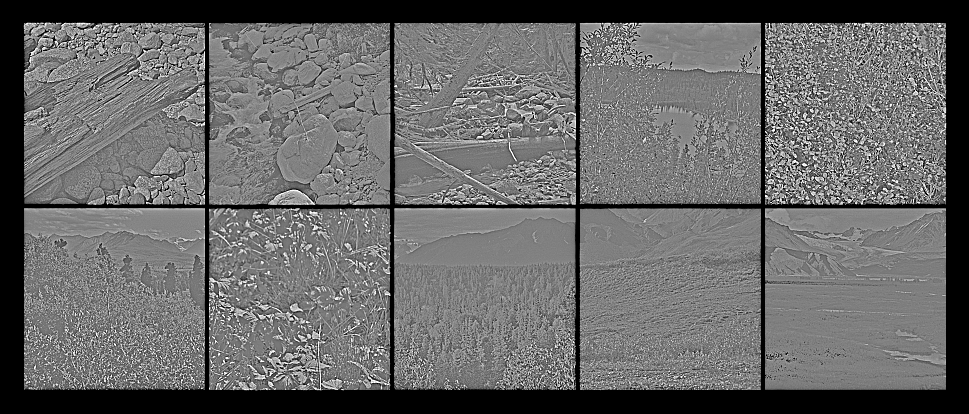

In [2]:
# Download data (20MB) to specified directory if not already downloaded.
img_path = "IMAGES.mat"
imgs = utils.maybe_download_data(img_path)  # standard normal
utils.visualize_imgs(imgs)

In [9]:
# Tunable parameters.
epochs = 3000
num_infer_iters = 750
batch_size = 100
lambd_div_sigma = .7  # Figure 4 description.
a_lr = 1e-3
eta = 1e-3

# If nonexistent, will generate patches in next step.
patch_dir = "patches_{}".format(epochs)

# Init variables
num_bases = 64
patch_size = 8  # 8x8 image # 16x16 in paper
N = patch_size * patch_size
torch.manual_seed(0)
rng = np.random.default_rng(seed=0)

# Sparse nonlinearity; we use |x|, but there are other possibilities.
def S(x): return torch.abs(x)  # Appears in Equation 4.
def S_prime(x): return torch.sign(x)  # Appears in Equation 5.

# For display purposes.
def loss_fn(I, Ihat, a, sigma):
    mse = F.mse_loss(Ihat, I).data  # Equation 3.
    sparseness = torch.sum(S(a/sigma))  # Equation 4.
    return mse, sparseness  # Equation 2.

# Initialize dict and visualize.
phi = torch.randn(N, num_bases)
phi = F.normalize(phi, dim=0)

patches already preprocessed at 'patches_3000'; loading


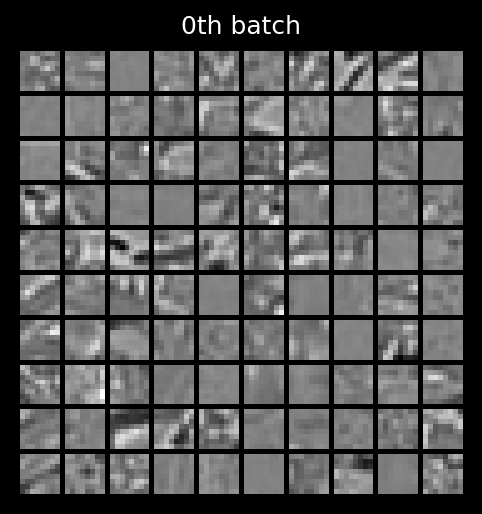

In [4]:
# # Load or process patches.
# # patches = utils.get_patches(imgs, epochs, batch_size, 64, "patches_7k_w_noise", rng) # w noise
# patches = utils.get_patches(imgs, epochs, batch_size, 64, "patches_4k", rng) # w/o noise
# utils.visualize_patches(patches[0,:,:], "0th batch")
# # patches = torch.load("patches_5k")

# Load or process patches.
patches = utils.get_patches(imgs, epochs, batch_size, N, patch_dir, rng)
utils.visualize_patches(patches[0, :, :], "0th batch")


In [10]:
# Initialize lists to store losses for plotting later.
total_losses = []
mses = []
sparse_losses = []

sigma = torch.sqrt(torch.var(patches))  # Fig. 4 description
lambd = lambd_div_sigma * sigma

for i in tqdm(range(epochs)):
    I = patches[i, :, :]
    a = torch.zeros(batch_size, num_bases)
    b = torch.mm(I, phi)  # (batch_size, num_bases)
    C = torch.mm(phi.T, phi) - torch.eye(num_bases)

    # This inner for loop uses Euler's method to learn coefficients a.
    for _ in range(num_infer_iters):
        # Obtain gradient based on Equation 5
        da = a_lr * (b - torch.mm(C, a.T).T - ((lambd_div_sigma) *
                                       S_prime(a/sigma)))  # (batch_size, num_bases)
        a += da  # (batch_size, num_bases)

    # Update basis gradients.
    Ihat = torch.mm(phi, a.T).T  # (batch_size, basis_size)
    dphi = eta * (torch.mm((I - Ihat).T, a))  # Equation 6, (basis_size, num_bases)
    phi += dphi

    # Normalize each basis to unit length.
    phi = F.normalize(phi, dim=0)

    # Calculate loss for plotting purposes.
    mse, sparseness = loss_fn(I, Ihat, a, sigma)
    total = -(-mse - lambd * sparseness) / batch_size  # Equation 2.
    total_losses.append(total)
    mses.append(mse)
    sparse_losses.append(sparseness)


100%|██████████| 3000/3000 [02:56<00:00, 17.04it/s]


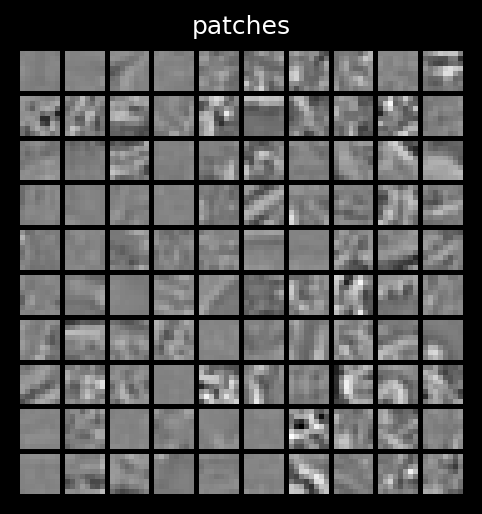

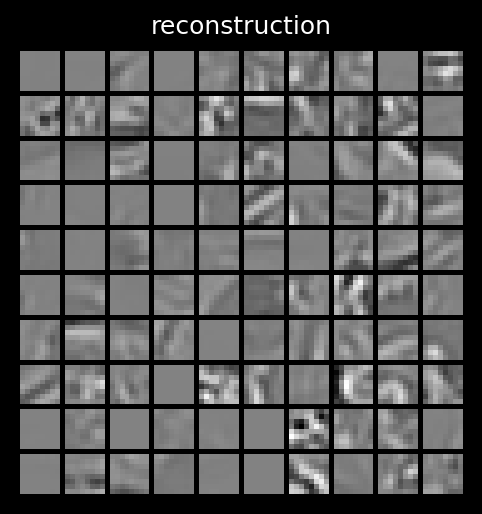

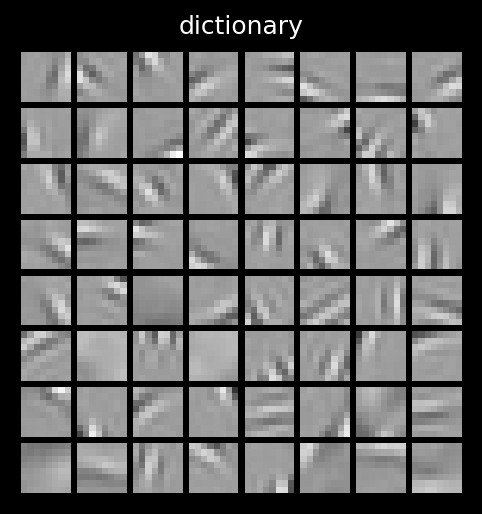

In [11]:
utils.visualize_patches(I, "patches")
utils.visualize_patches(Ihat, "reconstruction")
utils.visualize_bases(phi, "dictionary")

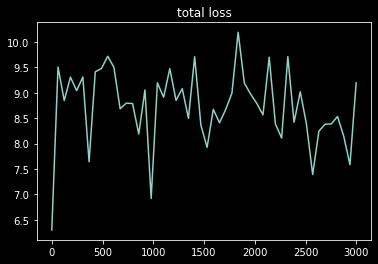

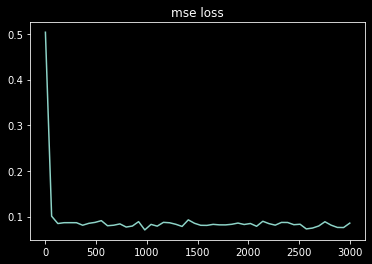

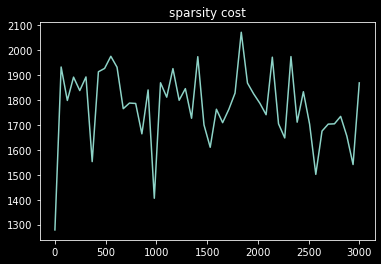

In [7]:
# Plot losses.
utils.plot_loss(total_losses, "total loss")
utils.plot_loss(mses, "mse loss")
utils.plot_loss(sparse_losses, "sparsity cost")


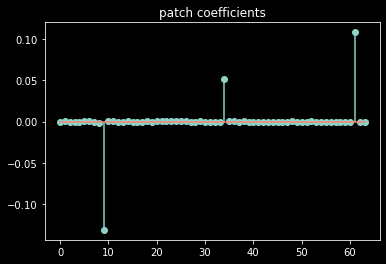

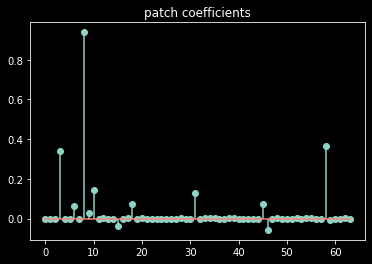

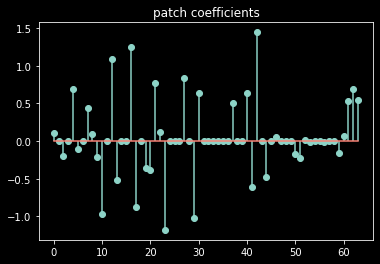

In [12]:
# Visualize the 0th, 50th, and 99th patch coefficients.
# a_sparsity = np.sum(np.array(a) == 0 * 1)/np.array(a).size
# print("sparsity: {}".format(a_sparsity))
utils.plot_coeffs(a[0])
utils.plot_coeffs(a[50])
utils.plot_coeffs(a[99])
